# 1. Evolución de la Dureza y el Esfuerzo Técnico

### ¿Cómo ha evolucionado la dureza del tdf?
### Para cuantificar esto, vamos a crear un Índice de Dureza Ponderado que combine el tipo de terreno con el kilometraje.

Metodología y FórmulaAsignamos un "Peso de Esfuerzo" (W) a cada kilómetro según el tipo de etapa:
<ul>
<li>1.0: Montaña y Cronoescalada (Máximo esfuerzo).</li>
<li>0.7: Media Montaña</li>
<li>0.6: Contrarreloj Individual (Intensidad máxima).</li>
<li>0.4: Pavé (Cobblestones) y Contrarreloj por Equipos.</li>
<li>0.2: Etapas Llanas (Flat) y sectores dobles.</li>
</ul>

Fórmulas calculadas:
<ol>
<li>Carga de Etapa (SW): SW = distancia_km \ W</li>
<li>Dureza Total del Tour (TTH): Sumatorio SW (Suma de la carga de todas las etapas de esa edición).</li>
<li>Intensidad Diaria (DI): TTH / Número de etapas</li>
</ol>


1. Creamos el dataframe par el analisis

In [22]:
import pandas as pd
import numpy as np

# Cargamos los datasets
df_stages = pd.read_csv('../data/processed/tdf_stages_clean.csv')
df_tours = pd.read_csv('../data/processed/tdf_tours_clean.csv')
df_winners = pd.read_csv('../data/processed/tdf_winners_clean.csv')

# display(df_stages.head(10))
# display(df_tours.head(10))
# display(df_winners.head(10))

# Estandarización de tipos de etapa (Corregir typos detectados)
type_mapping = {
                'Mountain time-trial': 'Mountain', # La contamos como montaña pura por esfuerzo
                'Double sector': 'Flat' # Históricamente solían ser llanas
                }

df_stages['type'] = df_stages['type'].replace(type_mapping)

# display(df_stages.head(10))

# Defnimos Pesos de Esfuerzo (Hardness Weights)
weights = {
    'Mountain': 1.0,
    'Hilly': 0.7,
    'Individual time-trial': 0.6,
    'Team time-trial': 0.4,
    'Cobblestones': 0.4,
    'Flat': 0.2
}

# Creamos la columna de Carga de Trabajo (Workload) por etapa
df_stages['stage_workload'] = df_stages.apply(
    lambda x: x['distance_in_km'] * weights.get(x['type'], 0.2), axis=1
)

# display(df_stages.head(10))

# Calculamosla dureza anual
# Sumamos la carga de trabajo y contamos las etapas reales
df_hardness_annual = df_stages.groupby('year').agg(
    total_workload=('stage_workload', 'sum'),
    actual_stages_count=('stage', 'count')
).reset_index()

# display (df_hardness_annual)

# Unimos la dureza calculada con los datos generales del Tour y del Ganador para rear el DataFrame para el analisis visual
df_analysis = pd.merge(df_tours, df_hardness_annual, on='year', how='inner')
df_analysis = pd.merge(df_analysis, df_winners[['year', 'avg speed']], on='year', how='left')

# display (df_analysis)

# Calculamos la Intensidad Diaria
df_analysis['daily_intensity'] = df_analysis['total_workload'] / df_analysis['actual_stages_count']

# display (df_analysis)

print("Dataframe de análisis de dureza (Primeras filas):")
display(df_analysis[['year', 'distance_in_km', 'total_workload', 'daily_intensity', 'abandon_rate', 'avg speed']].head())

#

Dataframe de análisis de dureza (Primeras filas):


,year,distance_in_km,total_workload,daily_intensity,abandon_rate,avg speed
0,1903,2428.0,784.8,130.800000,0.65,25.7
1,1904,2428.0,785.0,130.833333,0.83,25.3
2,1905,2994.0,1121.8,101.981818,0.60,NaN
3,1906,4637.0,1517.4,116.723077,0.83,NaN
4,1907,4488.0,1876.8,134.057143,0.65,NaN


Una vez calculado este dataframe maestro (df_analysis), procederemos a realizar las siguientes visualizaciones:

1. Composición del esfuerzo:

Veremos cómo ha cambiado la arquitectura de la carrera. En este gráfico agrupamos la carga de trabajo por décadas y tipos de etapa. Esto nos revelará si la montaña siempre ha sido la protagonista o si es un fenómeno moderno.

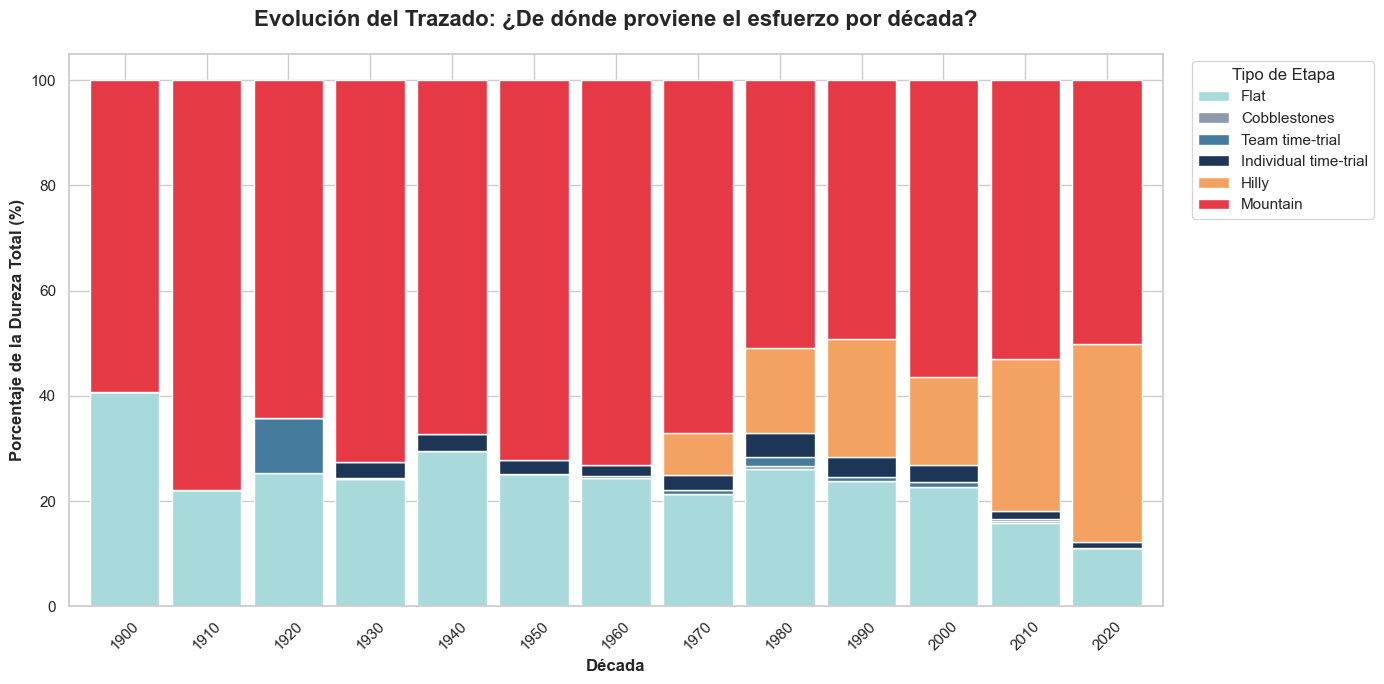

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración general de estilo
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (14, 7)

# Agrupamos por década
df_stages['decade'] = (df_stages['year'] // 10) * 10
workload_by_type = df_stages.groupby(['decade', 'type'])['stage_workload'].sum().reset_index()
workload_pivot = workload_by_type.pivot(index='decade', columns='type', values='stage_workload').fillna(0)

# Convertimos a porcentajes
workload_perc = workload_pivot.div(workload_pivot.sum(axis=1), axis=0) * 100

# Definimos los colores
colores_etapas = {
    'Flat': '#A8DADC', 
    'Cobblestones': '#8D99AE',
    'Team time-trial': '#457B9D', 
    'Individual time-trial': '#1D3557', 
    'Hilly': '#F4A261',
    'Mountain': '#E63946'
}
# Ordenamos columnas
orden_columnas = ['Flat', 'Cobblestones', 'Team time-trial', 'Individual time-trial', 'Hilly', 'Mountain']
workload_perc = workload_perc[orden_columnas]

# Dibujamos el gráfio
ax = workload_perc.plot(kind='bar', stacked=True, color=[colores_etapas[c] for c in orden_columnas], edgecolor='white', width=0.85)

plt.title('Evolución del Trazado: ¿De dónde proviene el esfuerzo por década?', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Década', fontsize=12, fontweight='bold')
plt.ylabel('Porcentaje de la Dureza Total (%)', fontsize=12, fontweight='bold')
plt.legend(title='Tipo de Etapa', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

2. Volumen vs densidad

Comprobamos si ha compensado el Tour la bajada de kilómetros totales introduciendo etapas más montañosas

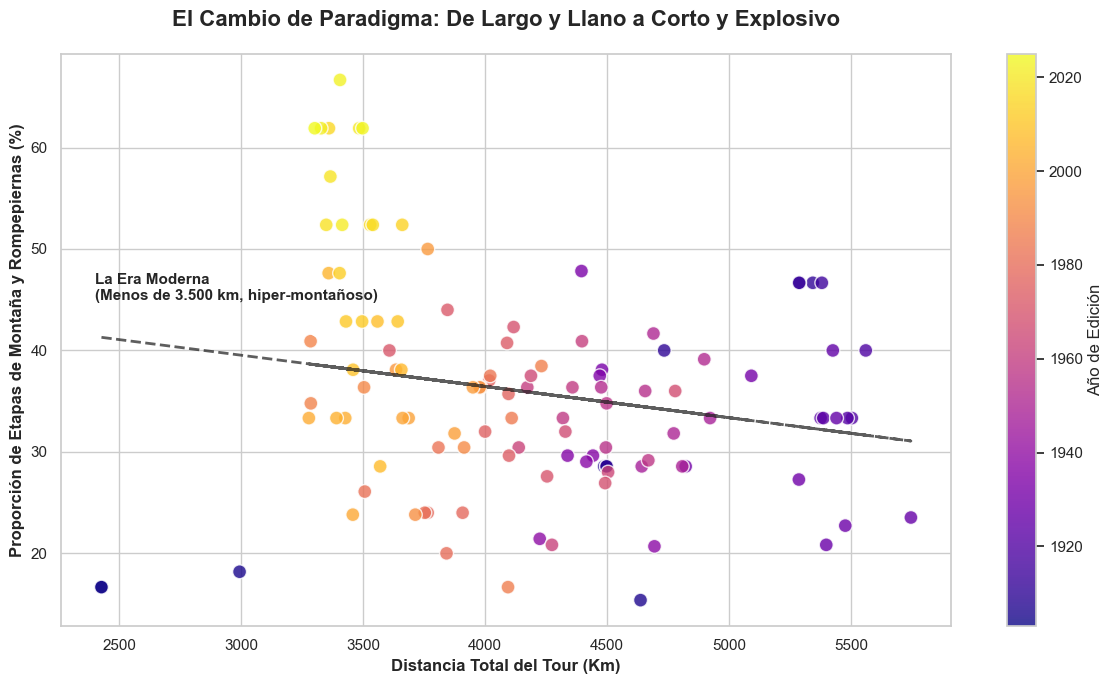

In [24]:
# Calculamos el porcentaje de etapas de Montaña/Media Montaña por año
mountain_stages = df_stages[df_stages['type'].isin(['Mountain', 'Hilly'])].groupby('year').size().reset_index(name='mountain_count')
df_analysis = pd.merge(df_analysis, mountain_stages, on='year', how='left').fillna(0)
df_analysis['mountain_percentage'] = (df_analysis['mountain_count'] / df_analysis['actual_stages_count']) * 100

# Creamos gráfico de dispersión
plt.figure(figsize=(12, 7))
scatter = plt.scatter(x=df_analysis['distance_in_km'], 
                      y=df_analysis['mountain_percentage'], 
                      c=df_analysis['year'], cmap='plasma', 
                      s=100, alpha=0.8, edgecolors='white', linewidth=1)
plt.colorbar(scatter, label='Año de Edición')

# Añadimos línea de tendencia
z = np.polyfit(df_analysis['distance_in_km'], df_analysis['mountain_percentage'], 1)
p = np.poly1d(z)
plt.plot(df_analysis['distance_in_km'], p(df_analysis['distance_in_km']), "k--", alpha=0.7, linewidth=2)

# Anotaciones
plt.title('El Cambio de Paradigma: De Largo y Llano a Corto y Explosivo', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Distancia Total del Tour (Km)', fontsize=12, fontweight='bold')
plt.ylabel('Proporción de Etapas de Montaña y Rompepiernas (%)', fontsize=12, fontweight='bold')

plt.annotate("La Era Heroica\n(Más de 4.500 km, casi todo llano)", xy=(5000, 10), xytext=(4300, 2),
             arrowprops=dict(facecolor='gray', arrowstyle="->"), fontsize=11, fontweight='bold')
plt.annotate("La Era Moderna\n(Menos de 3.500 km, hiper-montañoso)", xy=(3400, 40), xytext=(2400, 45),
             arrowprops=dict(facecolor='gray', arrowstyle="->"), fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

3. Supervivencia

¿Abandonan más ciclistas hoy que hace 100 años?


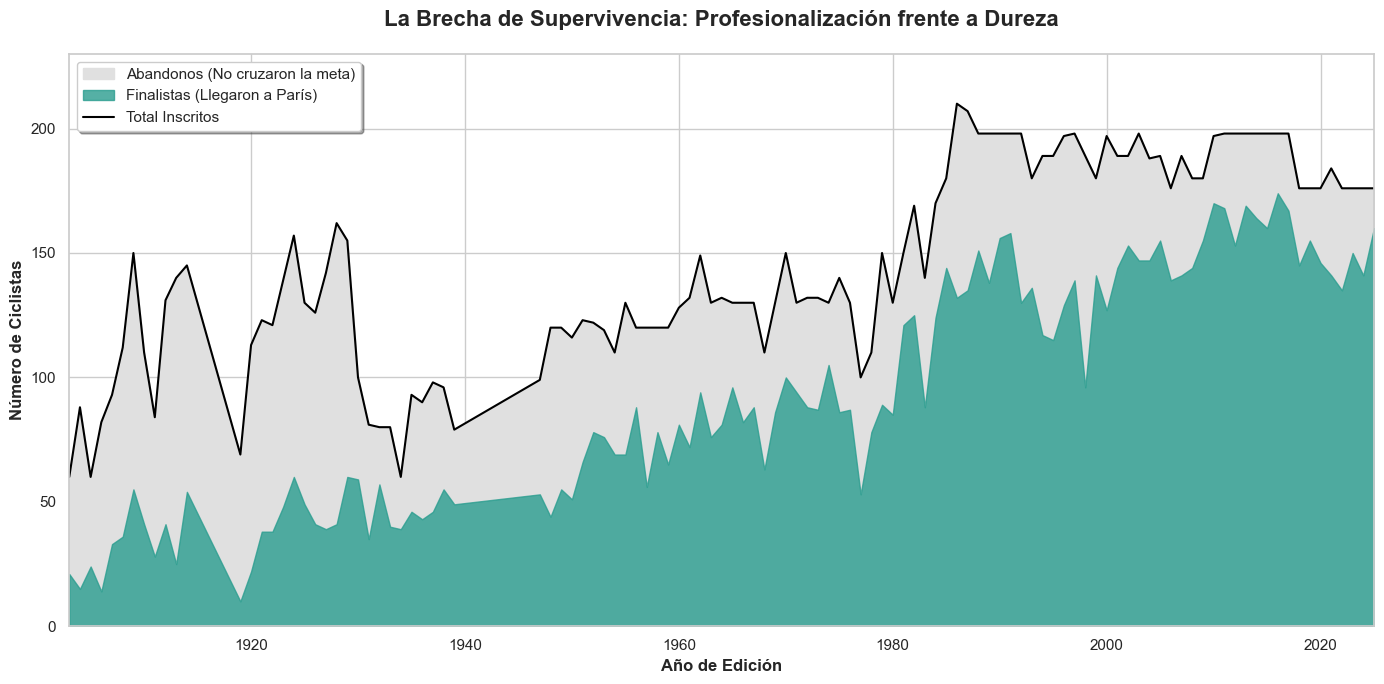

In [25]:
plt.figure(figsize=(14, 7))

# Rellenamos áreas para mostrar visualmente los abandonos
# Usamos fill_between para destacar el área entre los inscritos y los que terminan
plt.fill_between(df_analysis['year'], df_analysis['starters'], color='#e0e0e0', label='Abandonos (No cruzaron la meta)')
plt.fill_between(df_analysis['year'], df_analysis['finishers'], color='#2A9D8F', alpha=0.8, label='Finalistas (Llegaron a París)')

# Línea superior para enmarcar el total de inscritos
plt.plot(df_analysis['year'], df_analysis['starters'], color='black', linewidth=1.5, label='Total Inscritos')

# Detalles estéticos
plt.title('La Brecha de Supervivencia: Profesionalización frente a Dureza', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Año de Edición', fontsize=12, fontweight='bold')
plt.ylabel('Número de Ciclistas', fontsize=12, fontweight='bold')

# Reubicar leyenda
plt.legend(loc='upper left', fontsize=11, frameon=True, shadow=True)

# Limitar el eje X a los años reales del Tour
plt.xlim(df_analysis['year'].min(), df_analysis['year'].max())
plt.ylim(0, df_analysis['starters'].max() + 20)

plt.tight_layout()
plt.show()

4. Evolución de la velocdad media

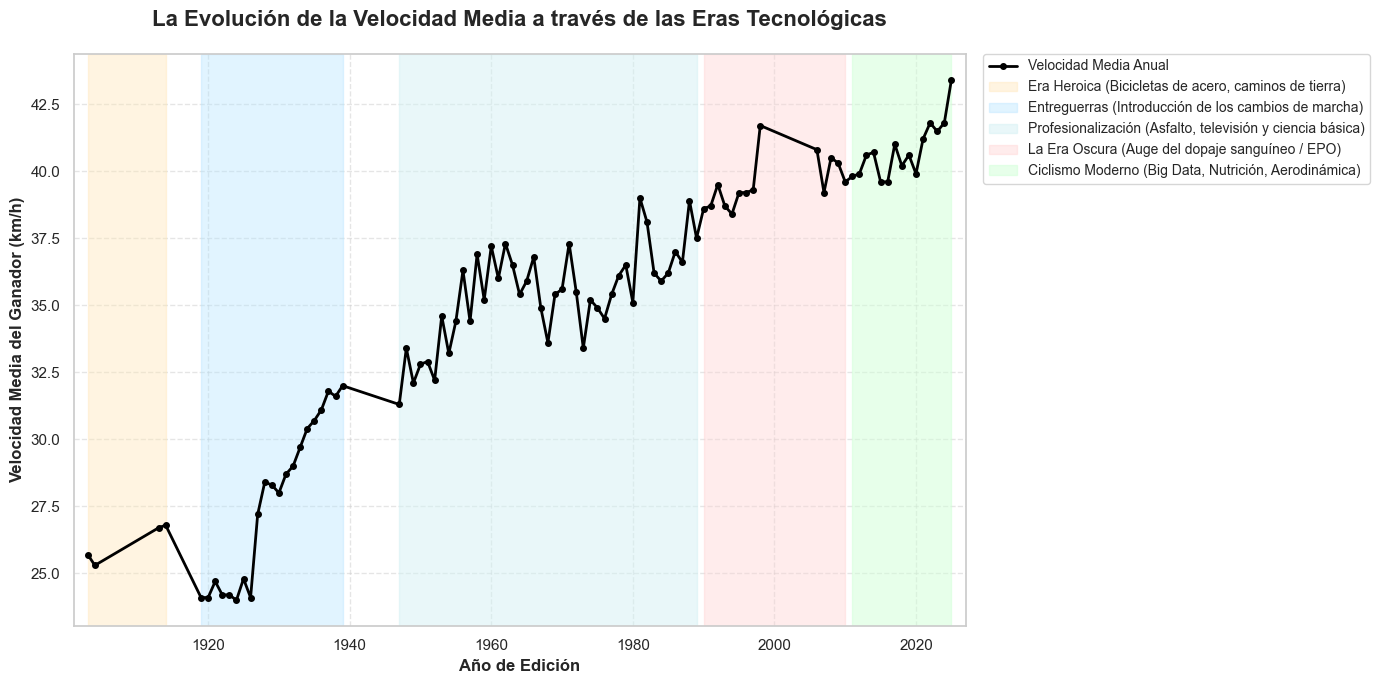

In [26]:
import matplotlib.pyplot as plt

# Preparamos los datos limpios de velocidad (eliminamos nulos de los primeros años)
df_speed = df_winners.dropna(subset=['avg speed']).sort_values('year').copy()

# Configuración del gráfico
plt.figure(figsize=(14, 7))

# Dibujamos la línea principal de velocidad
plt.plot(df_speed['year'], df_speed['avg speed'], color='black', linewidth=2, marker='o', markersize=4, label='Velocidad Media Anual')

# Añadimos fondos de color para las "Eras Históricas" (Background bands)
plt.axvspan(1903, 1914, color='#FFE5B4', alpha=0.4, label='Era Heroica (Bicicletas de acero, caminos de tierra)')
plt.axvspan(1919, 1939, color='#B4E4FF', alpha=0.4, label='Entreguerras (Introducción de los cambios de marcha)')
plt.axvspan(1947, 1989, color='#D4F1F4', alpha=0.5, label='Profesionalización (Asfalto, televisión y ciencia básica)')
plt.axvspan(1990, 2010, color='#FFD1D1', alpha=0.4, label='La Era Oscura (Auge del dopaje sanguíneo / EPO)')
plt.axvspan(2011, df_speed['year'].max(), color='#D1FFD7', alpha=0.5, label='Ciclismo Moderno (Big Data, Nutrición, Aerodinámica)')

# Detalles estéticos y etiquetas
plt.title('La Evolución de la Velocidad Media a través de las Eras Tecnológicas', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Año de Edición', fontsize=12, fontweight='bold')
plt.ylabel('Velocidad Media del Ganador (km/h)', fontsize=12, fontweight='bold')

# Colocamos la leyenda fuera del gráfico para que no tape los datos
plt.legend(loc='upper left', bbox_to_anchor=(1.02, 1), fontsize=10, borderaxespad=0.)

plt.grid(True, linestyle='--', alpha=0.5)
plt.xlim(df_speed['year'].min() - 2, df_speed['year'].max() + 2)
plt.tight_layout()
plt.show()

5. Evolución de la edad de los ganadores del tour

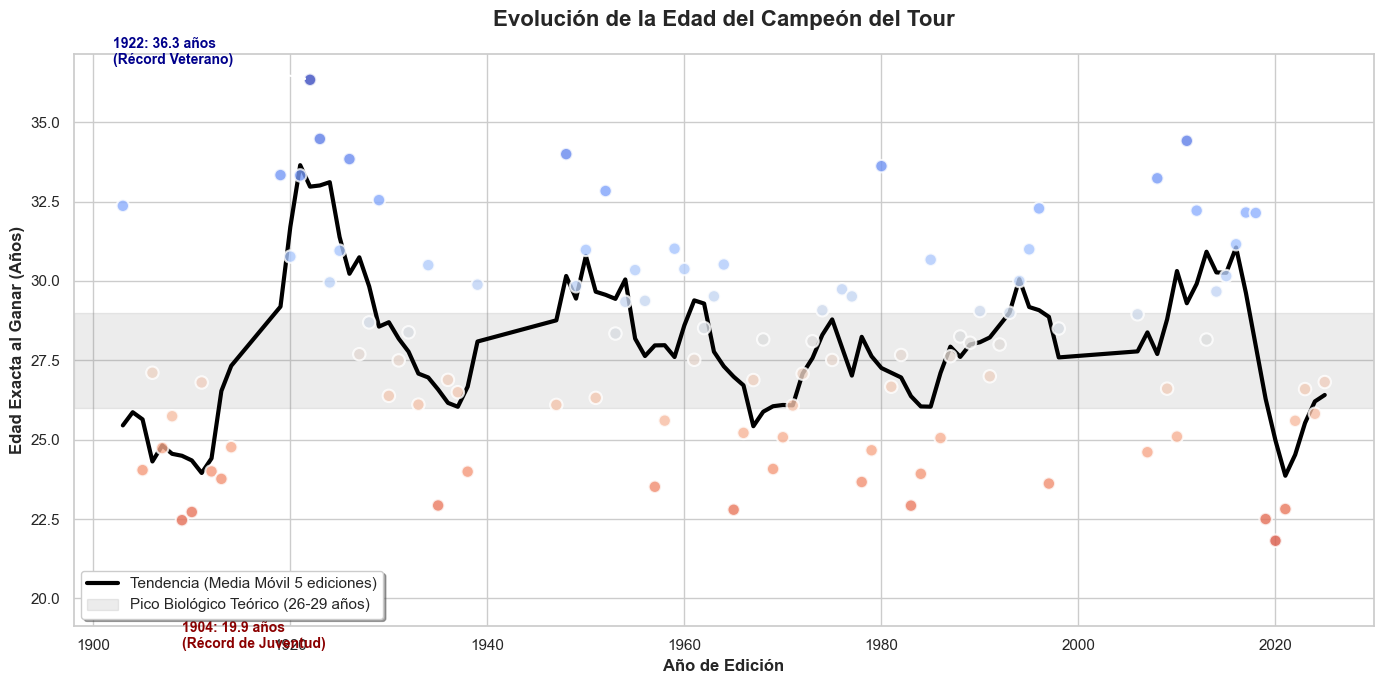

In [27]:

# Cargamos el dataset de ganadores
df_winners = pd.read_csv('../data/processed/tdf_winners_clean.csv')

# Calculamos la Edad Exacta al ganar
# Convertimos el año del Tour en una fecha aproximada (el 15 de julio)
df_winners['tour_date'] = pd.to_datetime(df_winners['year'].astype(str) + '-07-15')
df_winners['born'] = pd.to_datetime(df_winners['born'], errors='coerce')

# Calculamos la edad exacta en años
df_winners['age'] = (df_winners['tour_date'] - df_winners['born']).dt.days / 365.25

# Limpiamos valores nulos y preparamos para graficar
df_age = df_winners.dropna(subset=['age']).copy()
df_age.sort_values('year', inplace=True)

# CONFIGURACIÓN DEL GRÁFICO
plt.figure(figsize=(14, 7))
sns.set_theme(style="whitegrid")

# Puntos individuales
scatter = plt.scatter(df_age['year'], df_age['age'], 
                      c=df_age['age'], cmap='coolwarm_r', 
                      s=80, alpha=0.8, edgecolors='white', linewidth=1.5, zorder=3)

# Añadimos línea de tendencia (Media móvil de 5 años para mayor sensibilidad)
df_age['age_smooth'] = df_age['age'].rolling(window=5, center=True, min_periods=3).mean()
plt.plot(df_age['year'], df_age['age_smooth'], color='black', linewidth=3, 
         label='Tendencia (Media Móvil 5 ediciones)', zorder=2)

# Franja de la "Edad de Oro" biológica tradicional
plt.axhspan(26, 29, color='gray', alpha=0.15, label='Pico Biológico Teórico (26-29 años)', zorder=1)

# Anotaciones de los Extremos Históricos
youngest = df_age.loc[df_age['age'].idxmin()]
oldest = df_age.loc[df_age['age'].idxmax()]

plt.annotate(f"{int(youngest['year'])}: {youngest['age']:.1f} años\n(Récord de Juventud)", 
             xy=(youngest['year'], youngest['age']), 
             xytext=(youngest['year']+5, youngest['age']-1.5),
             arrowprops=dict(facecolor='darkred', arrowstyle="->", lw=1.5), fontsize=10, fontweight='bold', color='darkred')

plt.annotate(f"{int(oldest['year'])}: {oldest['age']:.1f} años\n(Récord Veterano)", 
             xy=(oldest['year'], oldest['age']), 
             xytext=(oldest['year']-20, oldest['age']+0.5),
             arrowprops=dict(facecolor='darkblue', arrowstyle="->", lw=1.5), fontsize=10, fontweight='bold', color='darkblue')

# Estética y Etiquetas
plt.title('Evolución de la Edad del Campeón del Tour', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Año de Edición', fontsize=12, fontweight='bold')
plt.ylabel('Edad Exacta al Ganar (Años)', fontsize=12, fontweight='bold')

plt.legend(loc='lower left', frameon=True, shadow=True)
plt.xlim(df_age['year'].min() - 5, df_age['year'].max() + 5)
plt.tight_layout()
plt.show()

6. Evolución del indice de masa corporal. 

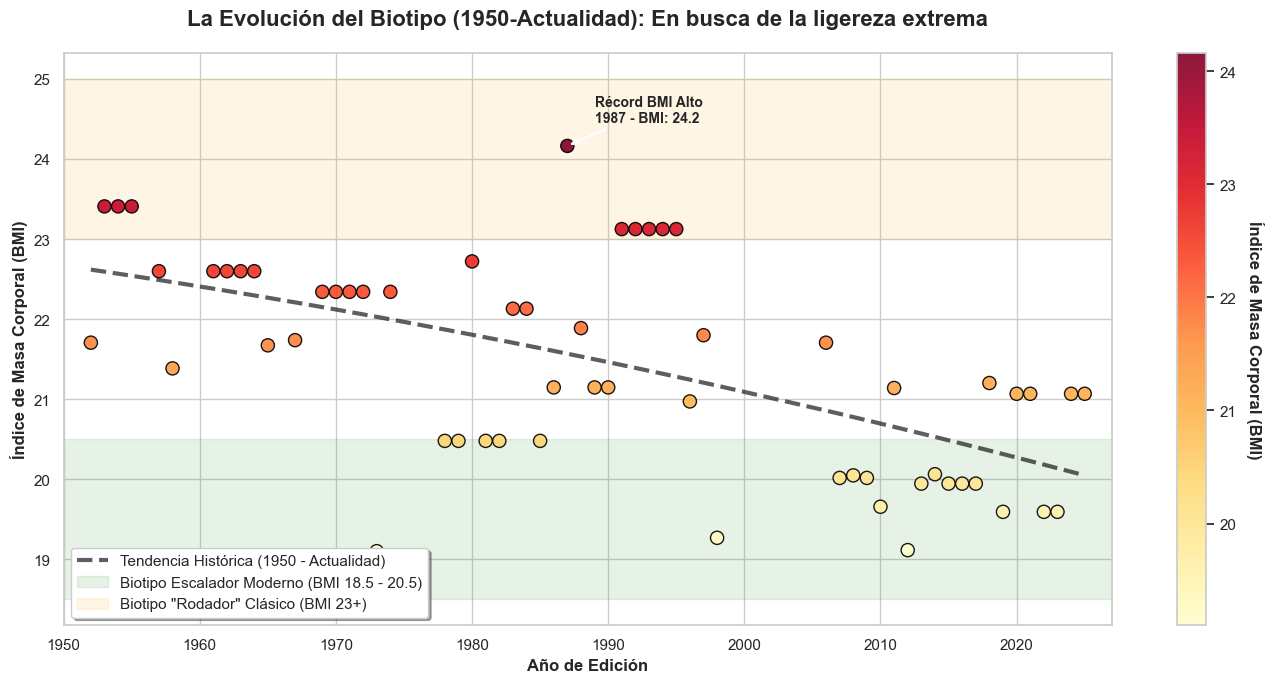

Evolución del BMI por Eras (Desde 1950):
- BMI Medio (1950-1990): 21.94
- BMI Medio Moderno (Últimos 15 años): 20.25


In [28]:
# Filtramos desde 1950 en adelante para asegurar datos médicos fiables
df_winners = df_winners[df_winners['year'] >= 1950].copy()

# Calcular el BMI
df_winners['bmi'] = df_winners['weight'] / (df_winners['height'] ** 2)

# Filtrar los nulos y ordenar por año
df_bmi = df_winners.dropna(subset=['bmi']).copy()
df_bmi.sort_values('year', inplace=True)

# CONFIGURACIÓN DEL GRÁFICO
plt.figure(figsize=(14, 7))
sns.set_theme(style="whitegrid")

# Gráfico de dispersión (Color según el valor del BMI)
scatter = plt.scatter(df_bmi['year'], df_bmi['bmi'], 
                      c=df_bmi['bmi'], cmap='YlOrRd', # Amarillo=Delgado, Rojo=Pesado
                      s=90, alpha=0.9, edgecolors='black', linewidth=1, zorder=3)

# Barra de color indicativa
cbar = plt.colorbar(scatter)
cbar.set_label('Índice de Masa Corporal (BMI)', rotation=270, labelpad=20, fontweight='bold')

# Añadir línea de tendencia
z = np.polyfit(df_bmi['year'], df_bmi['bmi'], 2)
p = np.poly1d(z)
plt.plot(df_bmi['year'], p(df_bmi['year']), "k--", alpha=0.7, linewidth=3, 
         label='Tendencia Histórica (1950 - Actualidad)', zorder=2)

# Franjas de referencia
plt.axhspan(18.5, 20.5, color='green', alpha=0.1, label='Biotipo Escalador Moderno (BMI 18.5 - 20.5)', zorder=1)
plt.axhspan(23, 25, color='orange', alpha=0.1, label='Biotipo "Rodador" Clásico (BMI 23+)', zorder=1)

# Anotaciones de casos extremos (Dinámicas, detectan el máx/mín automáticamente)
max_bmi = df_bmi.loc[df_bmi['bmi'].idxmax()]
min_bmi = df_bmi.loc[df_bmi['bmi'].idxmin()]

plt.annotate(f"Récord BMI Alto\n{int(max_bmi['year'])} - BMI: {max_bmi['bmi']:.1f}", 
             xy=(max_bmi['year'], max_bmi['bmi']), 
             xytext=(max_bmi['year']+2, max_bmi['bmi']+0.3),
             arrowprops=dict(facecolor='darkred', arrowstyle="->", lw=1.5), fontsize=10, fontweight='bold')

plt.annotate(f"Récord BMI Bajo\n{int(min_bmi['year'])} - BMI: {min_bmi['bmi']:.1f}", 
             xy=(min_bmi['year'], min_bmi['bmi']), 
             xytext=(min_bmi['year']-10, min_bmi['bmi']-0.5),
             arrowprops=dict(facecolor='darkgreen', arrowstyle="->", lw=1.5), fontsize=10, fontweight='bold')

# Estética y Etiquetas
plt.title('La Evolución del Biotipo (1950-Actualidad): En busca de la ligereza extrema', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Año de Edición', fontsize=12, fontweight='bold')
plt.ylabel('Índice de Masa Corporal (BMI)', fontsize=12, fontweight='bold')

plt.legend(loc='lower left', frameon=True, shadow=True)
plt.xlim(df_bmi['year'].min() - 2, df_bmi['year'].max() + 2)

plt.tight_layout()
plt.show()

# Resumen estadístico impreso
print(f"Evolución del BMI por Eras (Desde 1950):")
print(f"- BMI Medio (1950-1990): {df_bmi[df_bmi['year']<1990]['bmi'].mean():.2f}")
print(f"- BMI Medio Moderno (Últimos 15 años): {df_bmi[df_bmi['year']>=2010]['bmi'].mean():.2f}")